# ML için Veri Hazırlama: Gerçekçi bir senaryo

## Hikaye: Başlamadan Önce

Siz bir bankada veri bilimci olarak çalışıyorsunuz. Bir sabah maile bakıyorsunuz, business'tan, pazarlamadan ya da üst yönetimden bir talep düşmüş:

*"Batık kredi verme oranımız son 3 aylık periyotta çok yükseldi. Bunu nasıl düşürebiliriz?"*

**Sorular**:
- Batık kredilerimizin oranı neden yükseldi?
- Mevcut sistem bu kadar batıran kişilere neden kredi veriyor?
- Bunu nasıl düzeltiriz?

**Problem tanımı**:
- Başvurulardaki batık riskini önceden nasıl tahmin edebiliriz?

Bu problemi Machine Learning yapmadan çözemez miyiz?

- ML pahalıdır. 
- Geliştirme, deployment, monitoring, sürekli bakım... 
- Herkes hemen ML der ama çoğu zaman 5-10 basit kural işi çözer. 
- Eğer problem basit kurallarla çözülüyorsa, ML'e girmeyin.

**ML ile çözmeye karar verdik:** 
- Target tanımı ve oluşturulması
- Periyot belirlenmesi - train-test

**Veri seti hazırlığı**
- Database'den potansiyel kolon seçimi
- Domain bilgisi & Regülasyonlar
- Analitik yaklaşım
- sql based

**EDA: Exploratory Data Analysis**:
- Veriye ilk bakış
- Veri tipleri
- Betimsel istatistikler
- Varyasyon katsayısı
- Sürekli ve Kategorik Dağılımlar
- Aykırı değerler
- Korelasyonlar

**Baseline Model**:
- Lojistik regresyon

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)


In [10]:
train = pd.read_csv('../../data/raw/application_train.csv')
test = pd.read_csv('../../data/raw/application_test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain has TARGET: {('TARGET' in train.columns)}")
print(f"Test has TARGET: {('TARGET' in test.columns)}")
print(f"\nCommon features: {len(set(train.columns) & set(test.columns))}")

Train shape: (307511, 122)
Test shape: (48744, 121)

Train has TARGET: True
Test has TARGET: False

Common features: 121


In [11]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Target Distribution:
0 (No default): 282,686 (91.93%)
1 (Default): 24,825 (8.07%)


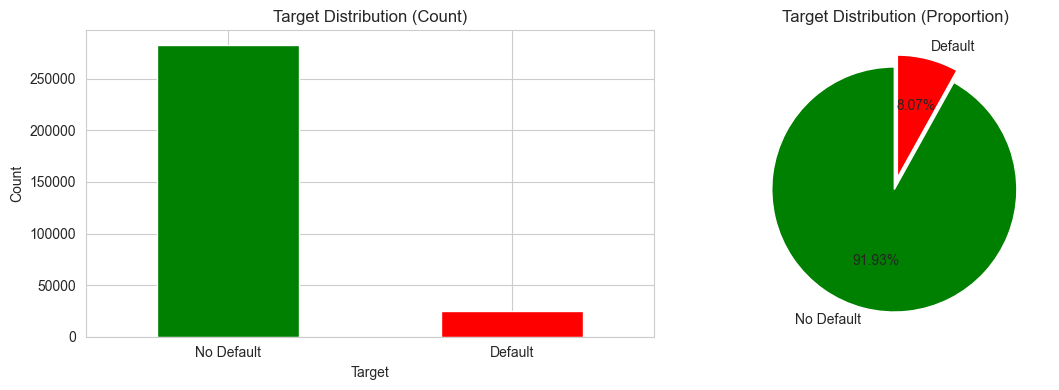

In [12]:
target_counts = train['TARGET'].value_counts()
target_pct = train['TARGET'].value_counts(normalize=True) * 100

print("Target Distribution:")
print(f"0 (No default): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"1 (Default): {target_counts[1]:,} ({target_pct[1]:.2f}%)")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart for count
train['TARGET'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Target Distribution (Count)')
ax[0].set_xlabel('Target')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['No Default', 'Default'], rotation=0)

# Pie chart for proportion
labels = ['No Default', 'Default']
colors = ['green', 'red']
explode = (0.05, 0.05)
ax[1].pie(train['TARGET'].value_counts().values, labels=labels, colors=colors, 
          autopct='%1.2f%%', startangle=90, explode=explode, textprops={'fontsize': 10})
ax[1].set_title('Target Distribution (Proportion)')

plt.tight_layout()
plt.show()

In [13]:
print("Data Types:")
print(train.dtypes.value_counts())

Data Types:
float64    65
int64      41
object     16
Name: count, dtype: int64


In [14]:
def analyze_columns(df):
    analysis = pd.DataFrame({
        'dtype': df.dtypes,
        'null_pct': (df.isnull().sum() / len(df) * 100).round(2),
        'unique_count': df.nunique(),
        'unique_pct': (df.nunique() / len(df) * 100).round(2)
    })
    
    analysis['category'] = 'numeric'
    analysis.loc[analysis['dtype'] == 'object', 'category'] = 'categorical'
    analysis.loc[analysis['unique_count'] == 1, 'category'] = 'constant'
    #analysis.loc[analysis['null_pct'] > 90, 'category'] = 'mostly_null'
    analysis.loc[analysis['unique_count'] == len(df), 'category'] = 'unique_id'
    
    return analysis

col_analysis = analyze_columns(train)
print("Column Analysis:")
col_analysis


Column Analysis:


,dtype,null_pct,unique_count,unique_pct,category
SK_ID_CURR,int64,0.00,307511,100.00,unique_id
TARGET,int64,0.00,2,0.00,numeric
NAME_CONTRACT_TYPE,object,0.00,2,0.00,categorical
CODE_GENDER,object,0.00,3,0.00,categorical
FLAG_OWN_CAR,object,0.00,2,0.00,categorical
FLAG_OWN_REALTY,object,0.00,2,0.00,categorical
CNT_CHILDREN,int64,0.00,15,0.00,numeric
AMT_INCOME_TOTAL,float64,0.00,2548,0.83,numeric
AMT_CREDIT,float64,0.00,5603,1.82,numeric
AMT_ANNUITY,float64,0.00,13672,4.45,numeric


In [15]:
missing_stats = pd.DataFrame({
    'train_count': len(train),
    'train_null_count': train.isnull().sum(),
    'train_missing_%': (train.isnull().sum() / len(train) * 100).round(2),
    'test_count': len(test),
    'test_null_count': test.isnull().sum(),
    'test_missing_%': (test.isnull().sum() / len(test) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['train_missing_%'] > 0]
missing_stats = missing_stats.sort_values('train_missing_%', ascending=False)

from IPython.display import display
print(f"Train observations: {len(train):,} | Test observations: {len(test):,}\n")
display(missing_stats[['train_count', 'train_null_count', 'train_missing_%', 'test_count', 'test_null_count', 'test_missing_%']])

Train observations: 307,511 | Test observations: 48,744



,train_count,train_null_count,train_missing_%,test_count,test_null_count,test_missing_%
COMMONAREA_MODE,307511,214865,69.87,48744,33495.0,68.72
COMMONAREA_AVG,307511,214865,69.87,48744,33495.0,68.72
COMMONAREA_MEDI,307511,214865,69.87,48744,33495.0,68.72
NONLIVINGAPARTMENTS_MODE,307511,213514,69.43,48744,33347.0,68.41
NONLIVINGAPARTMENTS_MEDI,307511,213514,69.43,48744,33347.0,68.41
NONLIVINGAPARTMENTS_AVG,307511,213514,69.43,48744,33347.0,68.41
FONDKAPREMONT_MODE,307511,210295,68.39,48744,32797.0,67.28
LIVINGAPARTMENTS_MODE,307511,210199,68.35,48744,32780.0,67.25
LIVINGAPARTMENTS_MEDI,307511,210199,68.35,48744,32780.0,67.25
LIVINGAPARTMENTS_AVG,307511,210199,68.35,48744,32780.0,67.25


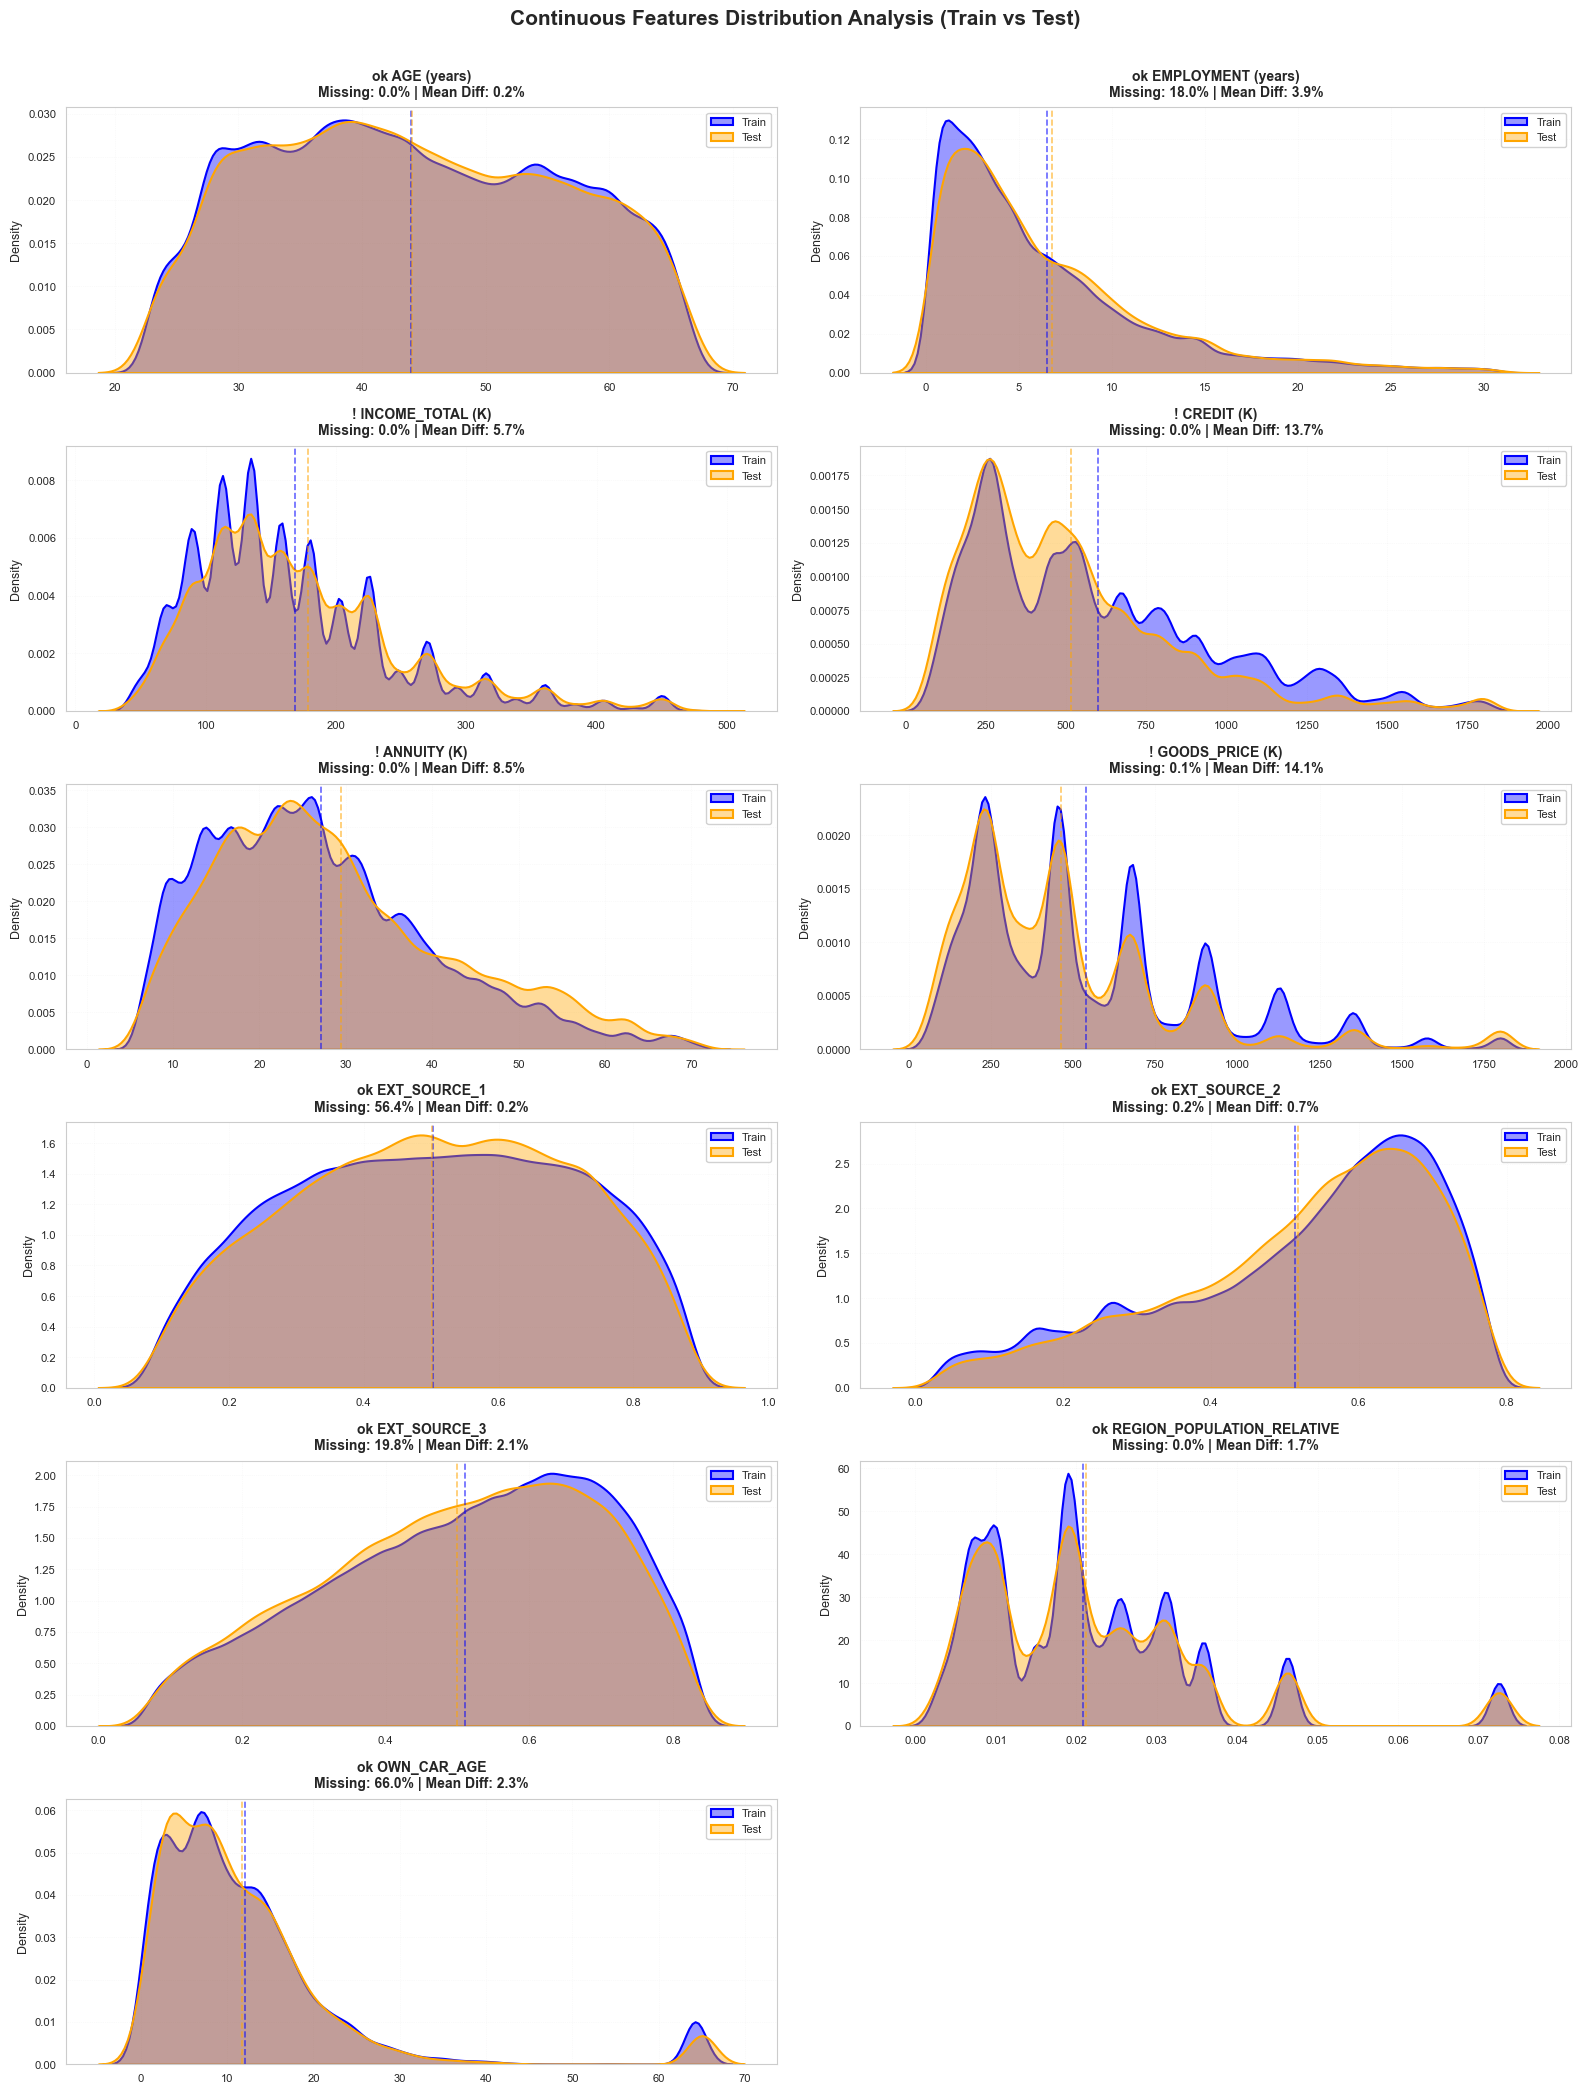

In [16]:
age_features = ['DAYS_BIRTH', 'DAYS_EMPLOYED']

amount_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

score_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

other_features = ['REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE']

selected_features = age_features + amount_features + score_features + other_features
selected_features = [f for f in selected_features if f in train.columns and f in test.columns]

train_plot = train[selected_features].copy()
test_plot = test[selected_features].copy()

feature_names_mapping = {}

for col in age_features:
    if col in train_plot.columns:
        if col == 'DAYS_BIRTH':
            train_plot[col] = (-train_plot[col] / 365).round(1)
            test_plot[col] = (-test_plot[col] / 365).round(1)
            feature_names_mapping[col] = 'AGE (years)'
        
        elif col == 'DAYS_EMPLOYED':
            train_plot[col] = train_plot[col].replace(365243, np.nan)
            test_plot[col] = test_plot[col].replace(365243, np.nan)
            train_plot[col] = (-train_plot[col] / 365).round(1)
            test_plot[col] = (-test_plot[col] / 365).round(1)
            feature_names_mapping[col] = 'EMPLOYMENT (years)'


for col in amount_features:
    if col in train_plot.columns:
        train_plot[col] = train_plot[col] / 1000
        test_plot[col] = test_plot[col] / 1000
        feature_names_mapping[col] = col.replace('AMT_', '') + ' (K)'

for col in score_features + other_features:
    if col in train_plot.columns:
        feature_names_mapping[col] = col

n_cols = 2
n_rows = int(np.ceil(len(selected_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3.5))
axes = axes.ravel()

for i, col in enumerate(selected_features):
    if col not in train_plot.columns:
        continue
    
    display_name = feature_names_mapping.get(col, col)
    
    train_data = train_plot[col].dropna()
    test_data = test_plot[col].dropna()
    
    combined_data = pd.concat([train_data, test_data])
    
    q01 = combined_data.quantile(0.01)
    q99 = combined_data.quantile(0.99)
    
    train_filtered = train_data[(train_data >= q01) & (train_data <= q99)]
    test_filtered = test_data[(test_data >= q01) & (test_data <= q99)]
    
    sns.kdeplot(train_filtered, ax=axes[i], label='Train', color='blue', fill=True, alpha=0.4, linewidth=1.5)
    sns.kdeplot(test_filtered, ax=axes[i], label='Test', color='orange', fill=True, alpha=0.4, linewidth=1.5)
    
    train_mean = train_data.mean()
    test_mean = test_data.mean()
    train_missing = train_plot[col].isna().sum() / len(train_plot) * 100
    mean_diff_pct = abs(train_mean - test_mean) / train_mean * 100 if train_mean != 0 else 0
    
    axes[i].axvline(train_mean, color='blue', linestyle='--', alpha=0.6, linewidth=1.2)
    axes[i].axvline(test_mean, color='orange', linestyle='--', alpha=0.6, linewidth=1.2)
    
    status = 'ok' if mean_diff_pct < 5 else '!'
    
    axes[i].set_title(
        f'{status} {display_name}\n'
        f'Missing: {train_missing:.1f}% | Mean Diff: {mean_diff_pct:.1f}%',
        fontsize=10, pad=8, fontweight='bold'
    )
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density', fontsize=9)
    axes[i].legend(loc='upper right', fontsize=8, framealpha=0.9)
    axes[i].grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
    axes[i].tick_params(labelsize=8)

for j in range(len(selected_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Continuous Features Distribution Analysis (Train vs Test)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
#plt.savefig('continuous_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

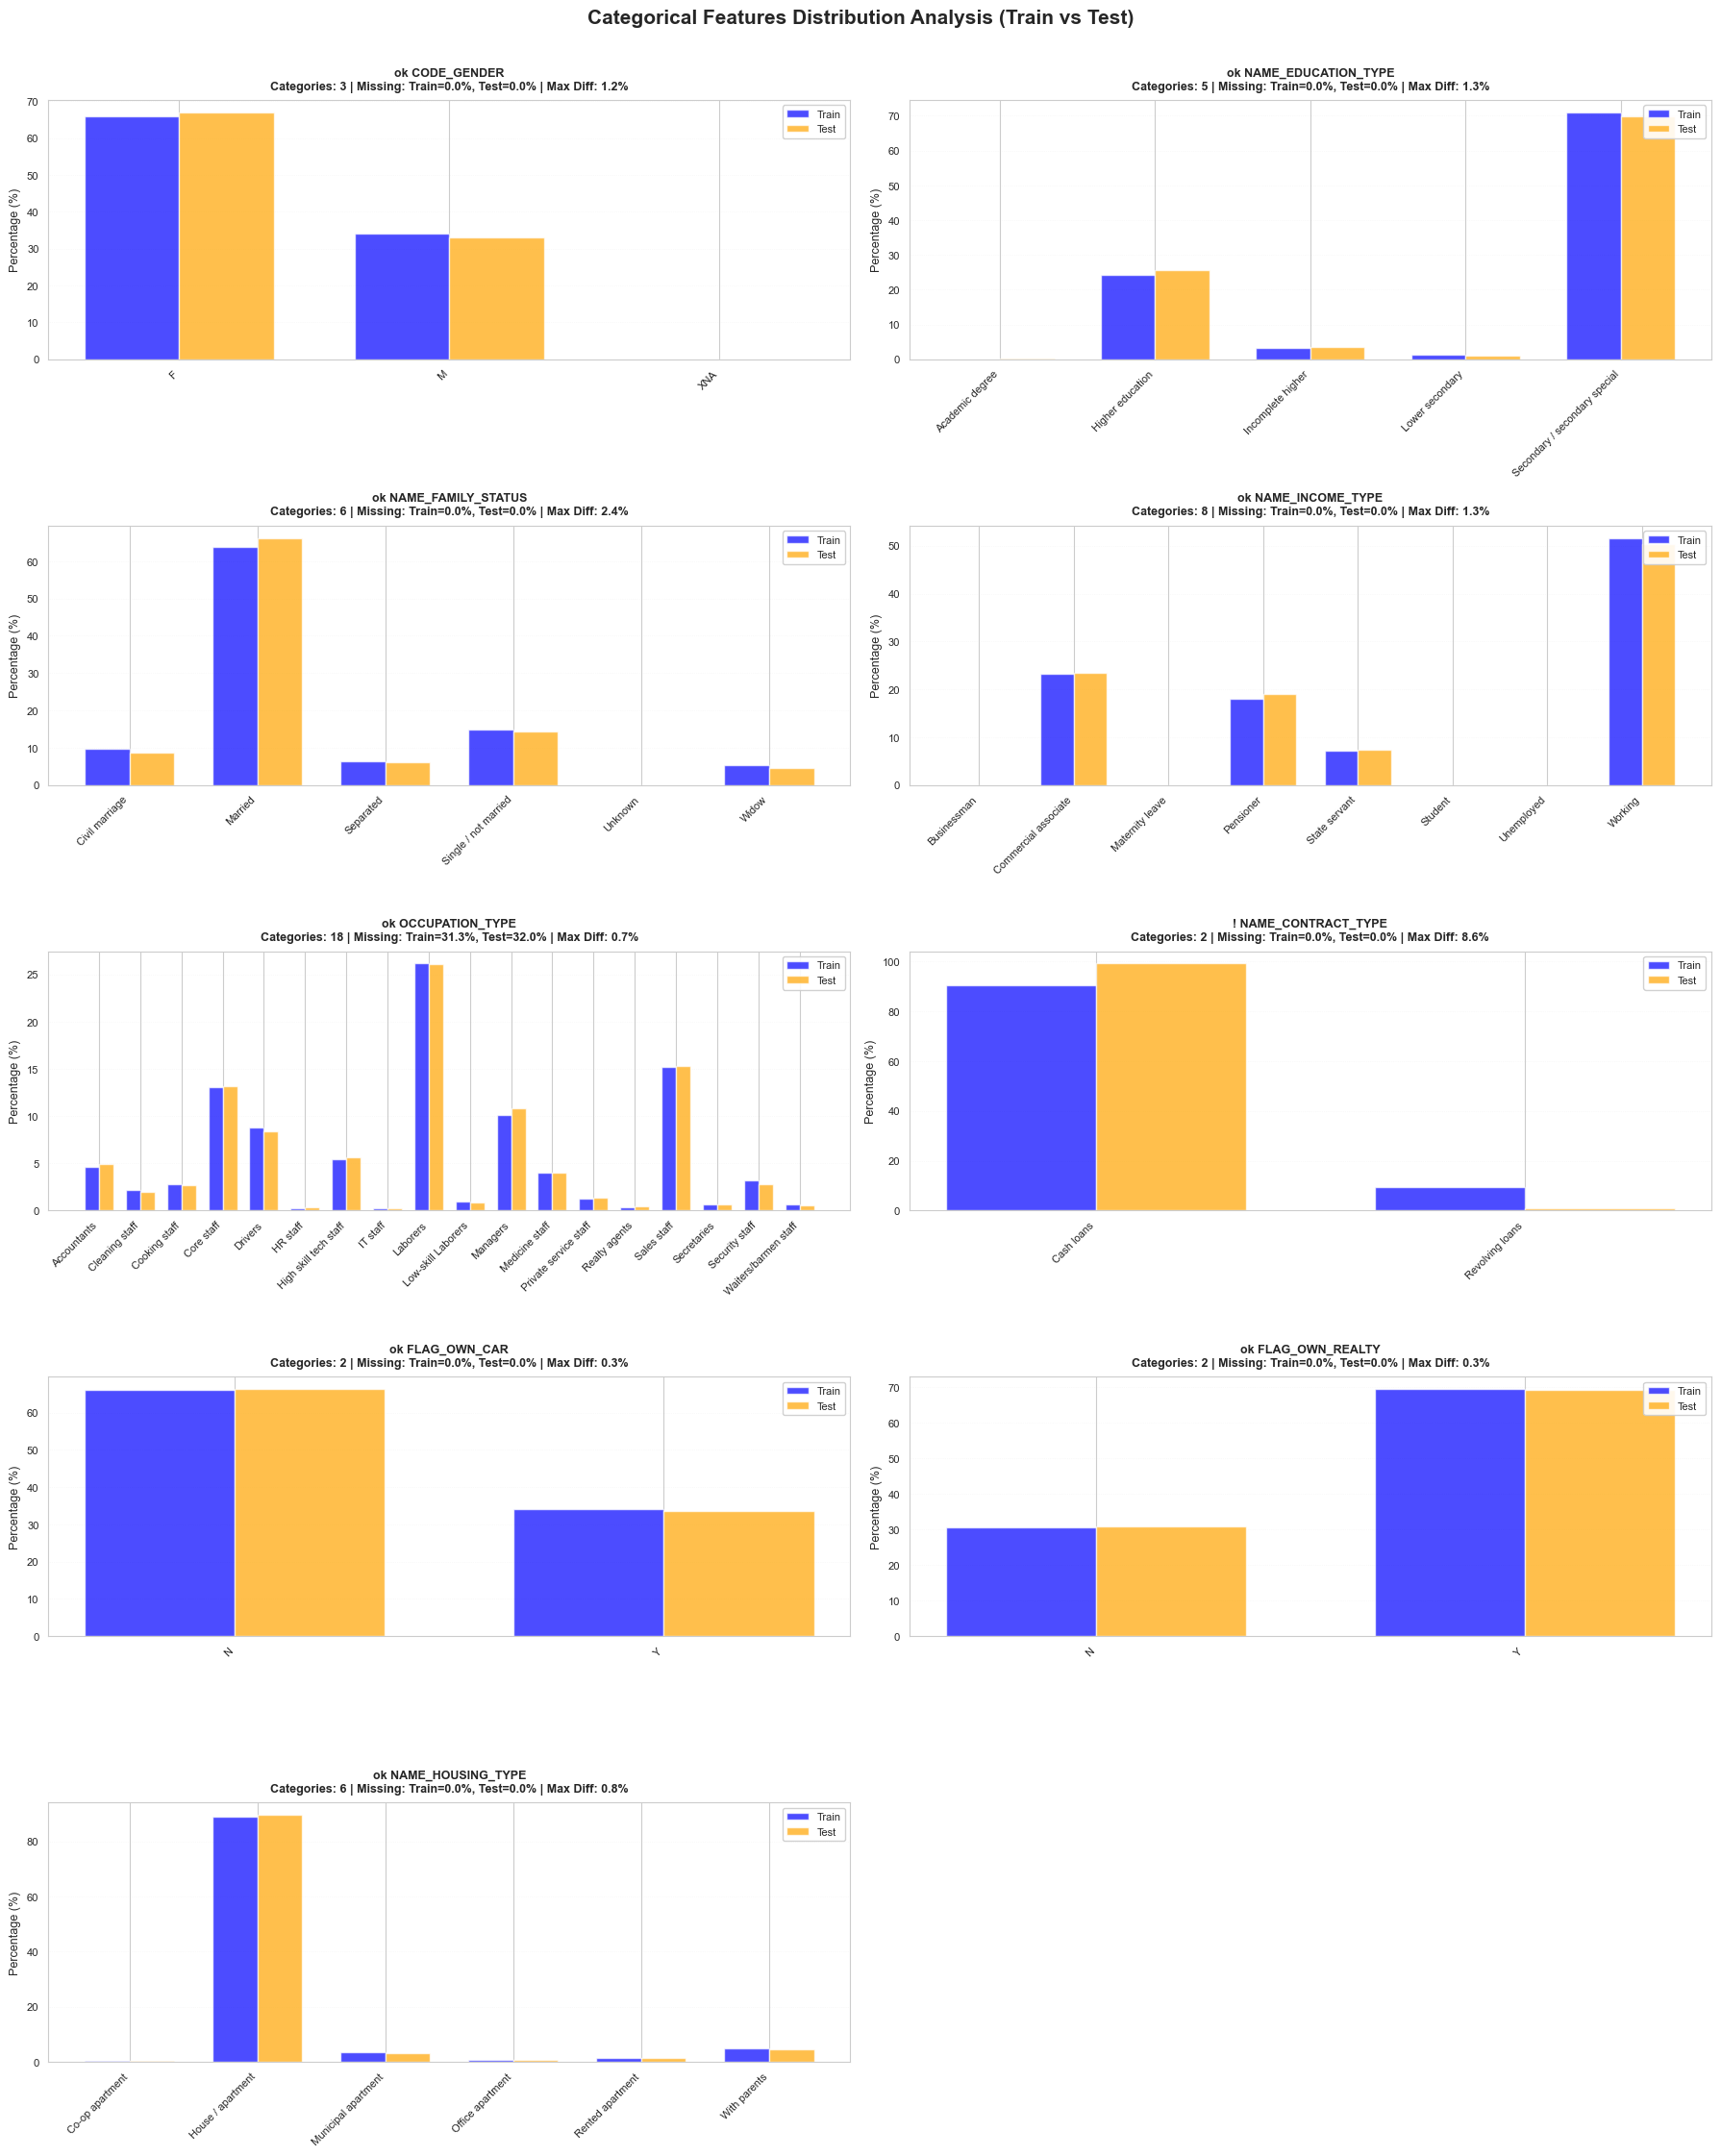

In [17]:
critical_categorical = [
    'CODE_GENDER',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE',
    'NAME_CONTRACT_TYPE',
    'NAME_CASH_LOAN_PURPOSE',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_HOUSING_TYPE',
]

critical_categorical = [f for f in critical_categorical if f in train.columns and f in test.columns]

n_cols = 2
n_rows = int(np.ceil(len(critical_categorical) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4.5))
axes = axes.ravel()

for i, col in enumerate(critical_categorical):
    
    train_counts = train[col].value_counts(normalize=True).sort_index()
    test_counts = test[col].value_counts(normalize=True).sort_index()
    
    all_categories = sorted(set(train_counts.index) | set(test_counts.index))
    
    train_pct = [train_counts.get(cat, 0) * 100 for cat in all_categories]
    test_pct = [test_counts.get(cat, 0) * 100 for cat in all_categories]
    
    x = np.arange(len(all_categories))
    width = 0.35
    
    axes[i].bar(x - width/2, train_pct, width, label='Train', color='blue', alpha=0.7)
    axes[i].bar(x + width/2, test_pct, width, label='Test', color='orange', alpha=0.7)
    
    train_missing = train[col].isna().sum() / len(train) * 100
    test_missing = test[col].isna().sum() / len(test) * 100
    n_categories = len(all_categories)
    
    max_diff = max([abs(train_pct[j] - test_pct[j]) for j in range(len(all_categories))])
    status = 'ok' if max_diff < 5 else '!'
    
    axes[i].set_title(
        f'{status} {col}\n'
        f'Categories: {n_categories} | Missing: Train={train_missing:.1f}%, Test={test_missing:.1f}% | Max Diff: {max_diff:.1f}%',
        fontsize=9, pad=8, fontweight='bold'
    )
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percentage (%)', fontsize=9)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=7)
    axes[i].legend(loc='upper right', fontsize=8, framealpha=0.9)
    axes[i].grid(True, alpha=0.2, linestyle=':', linewidth=0.5, axis='y')
    axes[i].tick_params(labelsize=8)

for j in range(len(critical_categorical), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Categorical Features Distribution Analysis (Train vs Test)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('categorical_features_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

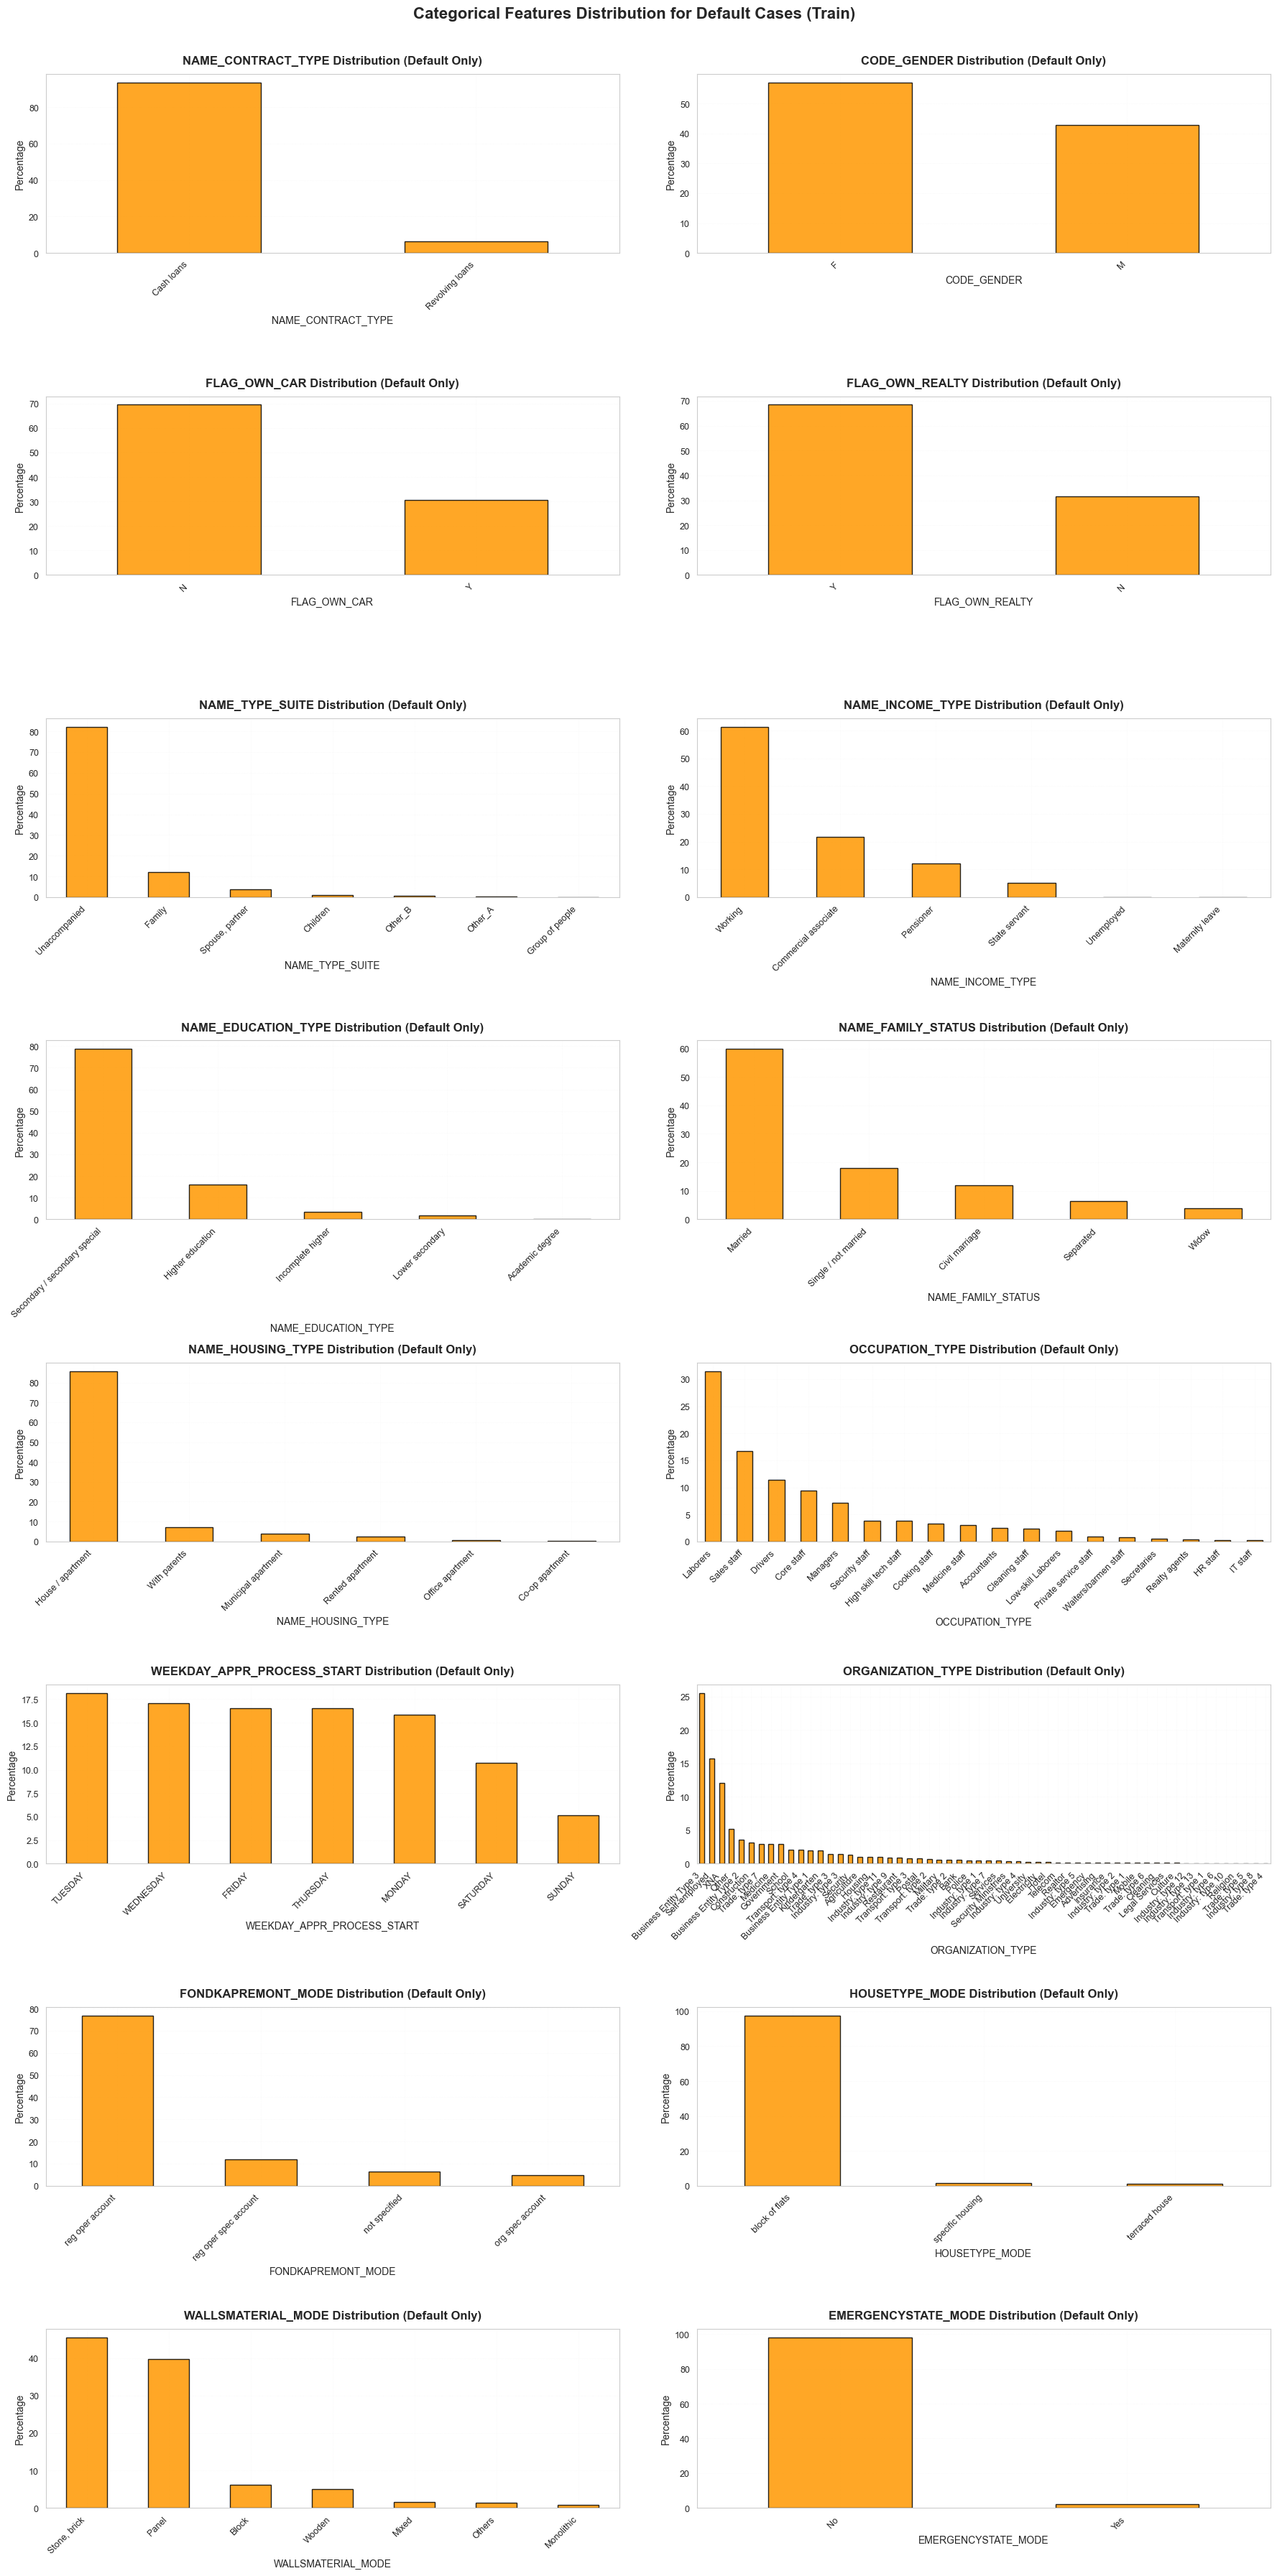

In [18]:
# Improved categorical feature distributions for default cases (TARGET==1) in train
categorical_features = train.select_dtypes(include='object').columns.tolist()
categorical_features = [col for col in categorical_features if col != 'dataset']

train_default = train[train['TARGET'] == 1]

n_cols = 2
n_rows = int(np.ceil(len(categorical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4.5))
axes = axes.ravel()

bar_color = '#FF9800'  # visually appealing orange

for i, col in enumerate(categorical_features):
    if col not in train_default.columns:
        continue
    value_counts = train_default[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], color=bar_color, alpha=0.85, edgecolor='black')
    axes[i].set_title(f'{col} Distribution (Default Only)', fontsize=12, fontweight='bold', pad=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage')
    axes[i].grid(True, alpha=0.2, linestyle=':', linewidth=0.5)
    axes[i].tick_params(labelsize=9)
    axes[i].set_axisbelow(True)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

for j in range(len(categorical_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Categorical Features Distribution for Default Cases (Train)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

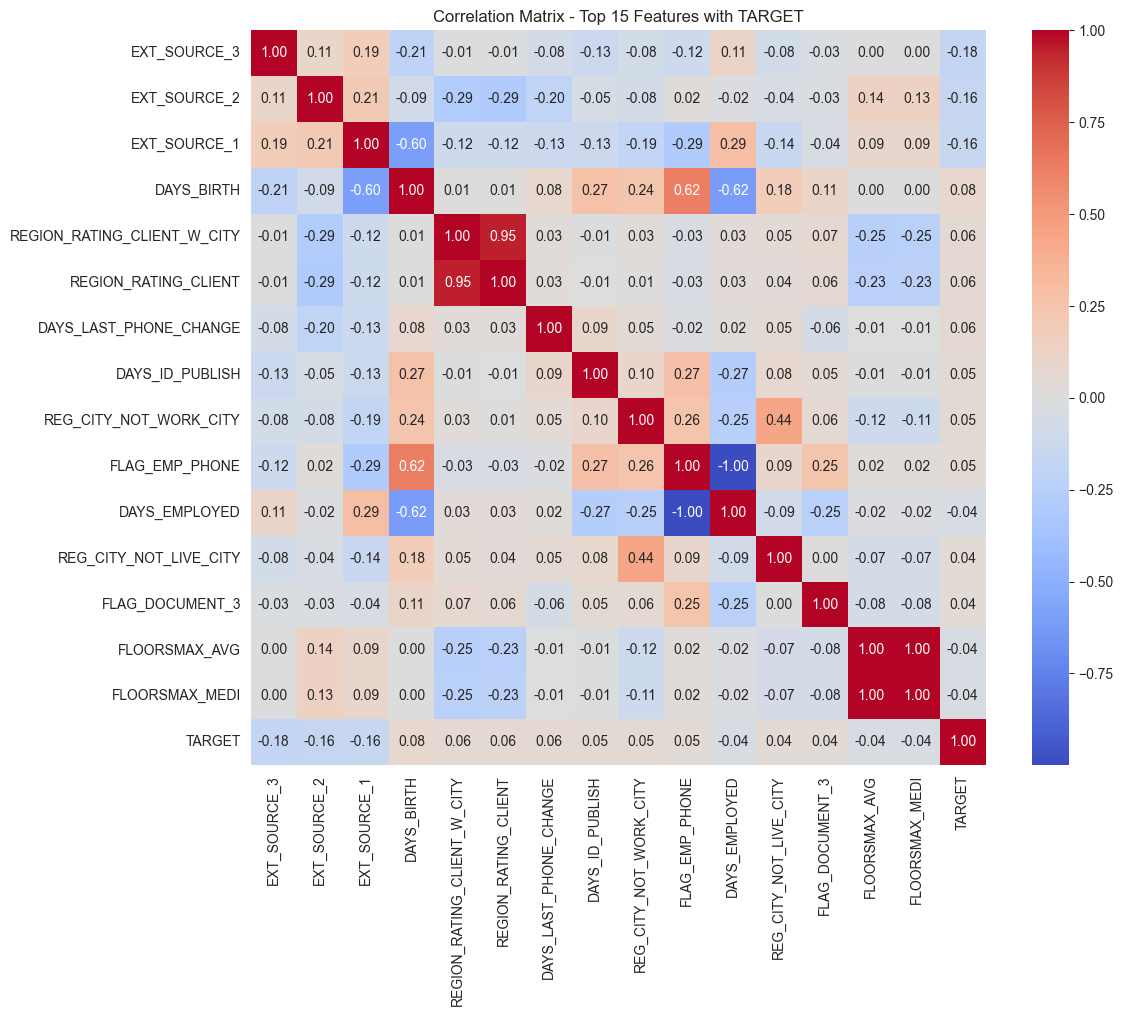

In [19]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'SK_ID_CURR' in numeric_cols:
    numeric_cols.remove('SK_ID_CURR')
if 'TARGET' in numeric_cols:
    numeric_cols.remove('TARGET')

correlations = train[numeric_cols + ['TARGET']].corr()['TARGET'].sort_values(ascending=False)

top_features = correlations.abs().sort_values(ascending=False).head(16).index.tolist()
top_features.remove('TARGET')

plt.figure(figsize=(12, 10))
corr_matrix = train[top_features + ['TARGET']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix - Top 15 Features with TARGET')
plt.tight_layout()
plt.show()



### Baseline Model


In [20]:
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
mlflow.lightgbm.autolog(disable=True)


import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


### Feature Selection

Eksik veri oranı düşük ve domain olarak etkili olacağını düşündüğümüz featureleri seçelim.

Explainability ve regülasyon/uyumluluk açısından, din, cinsiyet, eğitim gibi değişkenleri modele dahil etmek sorun yaratabilir. Özellikle başvurusu reddedilen bir müşteriye "Neden reddedildi?" sorusunu cevaplarken 'erkek' olduğu için reddedildi demek bussiness olarak uygun olmaz.

Bu tür değişkenler model performansını geliştirse bile, business tarafı production'da kullanımına onay vermeyebilir. Bu yüzden bu tip hassas değişkenler final modelden çıkarılabilir.

`'CNT_CHILDREN', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',`

In [21]:
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

categorical_features = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE'
]

features = numerical_features + categorical_features



In [22]:
df = train.copy()

X = df[features].copy()
y = df['TARGET'].copy()

print(f"Selected features: {len(features)}")
print(f"Numerical: {len(numerical_features)}, Categorical: {len(categorical_features)}")

Selected features: 36
Numerical: 25, Categorical: 11


In [23]:
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
print("\nTop 10 features by missing %:")
print(missing_pct.head(10))



Top 10 features by missing %:
EXT_SOURCE_1                  56.381073
OCCUPATION_TYPE               31.345545
EXT_SOURCE_3                  19.825307
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
dtype: float64


In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"\nTrain target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nVal target distribution:\n{y_val.value_counts(normalize=True)}")


Train size: 246008 (80.0%)
Val size: 61503 (20.0%)

Train target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Val target distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


In [25]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_log = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

log_pipeline = Pipeline([
    ('preprocessor', preprocessor_log),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    ))
])

print("Logistic Regression pipeline created")


Logistic Regression pipeline created


In [26]:
%%time

log_pipeline.fit(X_train, y_train)

print("Training complete")


Training complete
CPU times: total: 2min 32s
Wall time: 19.8 s


In [27]:
y_train_pred_proba_log = log_pipeline.predict_proba(X_train)[:, 1]
y_val_pred_proba_log = log_pipeline.predict_proba(X_val)[:, 1]
y_val_pred_log = log_pipeline.predict(X_val)

train_auc_log = roc_auc_score(y_train, y_train_pred_proba_log)
val_auc_log = roc_auc_score(y_val, y_val_pred_proba_log)
precision_log = precision_score(y_val, y_val_pred_log)
recall_log = recall_score(y_val, y_val_pred_log)
f1_log = f1_score(y_val, y_val_pred_log)

print("Logistic Regression Results:")
print(f"Train ROC-AUC: {train_auc_log:.4f}")
print(f"Val ROC-AUC: {val_auc_log:.4f}")
print(f"Val Precision: {precision_log:.4f}")
print(f"Val Recall: {recall_log:.4f}")
print(f"Val F1-Score: {f1_log:.4f}")


Logistic Regression Results:
Train ROC-AUC: 0.7449
Val ROC-AUC: 0.7455
Val Precision: 0.1604
Val Recall: 0.6755
Val F1-Score: 0.2593


In [28]:
cm_log = confusion_matrix(y_val, y_val_pred_log)
print("Confusion Matrix (Validation):")
print(cm_log)

Confusion Matrix (Validation):
[[38984 17554]
 [ 1611  3354]]



**Matrix Breakdown:**
- True Negatives (38,984): İyi müşteri, model kabul etti - DOĞRU
- False Positives (17,554): İyi müşteri, model reddetti - YANLIŞ (fırsat kaybı)
- False Negatives (1,611): Riskli müşteri, model kabul etti - YANLIŞ (batık kredi)
- True Positives (3,354): Riskli müşteri, model reddetti - DOĞRU

**Business Impact:**
- 1,611 batık kredi sisteme girdi
- 17,554 iyi müşteri haksız yere reddedildi

---

### Performance Metrics

**ROC-AUC Score**
- Train: 0.7449
- Validation: 0.7455
- Interpretation: Model iyi-kötü müşteriyi %74.5 ayırt edicilikle ayırıyor
- Train vs Val fark minimal - overfitting yok

**Precision: 0.1604 (16%)**
- Formula: TP / (TP + FP) = 3,354 / 20,908
- Meaning: Model "riskli" dediğinde sadece %16'sı gerçekten riskli
- Problem: Çok yüksek false positive rate

**Recall: 0.6755 (67.5%)**
- Formula: TP / (TP + FN) = 3,354 / 4,965
- Meaning: Gerçek riskli müşterilerin %67.5'ini yakalıyoruz
- Problem: %32.5 (1,611 kişi) kaçıyor

**F1-Score: 0.2593 (26%)**
- Precision ve Recall'ın harmonik ortalaması
- Düşük çıkması precision'ın çok düşük olmasından


In [29]:
feature_names_log = (numerical_features + 
                     log_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())

coefficients = log_pipeline.named_steps['classifier'].coef_[0]
feature_importance_log = pd.DataFrame({
    'feature': feature_names_log,
    'coefficient': np.abs(coefficients)
}).sort_values('coefficient', ascending=False)

print("\nTop 20 Important Features (Logistic Regression):")
print(feature_importance_log.head(20))



Top 20 Important Features (Logistic Regression):
                                               feature  coefficient
37                          NAME_INCOME_TYPE_Pensioner     5.718252
141                              ORGANIZATION_TYPE_XNA     5.108279
5                                        DAYS_EMPLOYED     4.916831
42                 NAME_EDUCATION_TYPE_Academic degree     2.202240
41                            NAME_INCOME_TYPE_Working     2.034894
38                      NAME_INCOME_TYPE_State servant     1.951324
35               NAME_INCOME_TYPE_Commercial associate     1.936467
133                    ORGANIZATION_TYPE_Trade: type 5     1.069978
132                    ORGANIZATION_TYPE_Trade: type 4     1.061709
3                                      AMT_GOODS_PRICE     0.938618
120                          ORGANIZATION_TYPE_Realtor     0.903918
1                                           AMT_CREDIT     0.857476
45                 NAME_EDUCATION_TYPE_Lower secondary     0.74617

In [30]:
mlflow_tracking_uri = os.path.join(os.getcwd(), 'mlruns')
mlflow.set_tracking_uri(f"file:///{mlflow_tracking_uri}")


mlflow.set_experiment("data_preparation_baseline_models")

with mlflow.start_run(run_name="logistic_regression_v1"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("n_features", len(features))
    
    mlflow.log_metric("train_auc", train_auc_log)
    mlflow.log_metric("val_auc", val_auc_log)
    mlflow.log_metric("val_precision", precision_log)
    mlflow.log_metric("val_recall", recall_log)
    mlflow.log_metric("val_f1", f1_log)
    
    mlflow.sklearn.log_model(log_pipeline, "model")
    
    feature_config = {
        'all_features': features,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features
    }
    with open('features_log.json', 'w') as f:
        json.dump(feature_config, f, indent=2)
    mlflow.log_artifact('features_log.json')
    
    cm_data = {
        'confusion_matrix': cm_log.tolist(),
        'labels': ['No Default', 'Default']
    }
    with open('confusion_matrix_log.json', 'w') as f:
        json.dump(cm_data, f, indent=2)
    mlflow.log_artifact('confusion_matrix_log.json')

print("Logged Logistic Regression to MLflow")

2025/11/17 21:38:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/17 21:39:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/17 21:39:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Logistic Regression to MLflow
